In [2]:
# Create a dataloaders for the dataset
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from src.dataset import AminoAcidDataset
from src.model import AminoAcidCNN
from src.train import train_model, evaluate_model


### We start with loading our custom AminoAcidDataset class

The class reads a .pdb file containing amino acids extracted from the PDB. Each amino acid is seperated by "END" statements, and only contains the heavy atom positions. In addition, only amino acids with complet heavy atom positions are considered.
<p>  
The Augementation ...


In [2]:
torch.cuda.is_available()

False

In [8]:
# Create an instance of the dataset
dataset = AminoAcidDataset('data/amino_acids_augmented.pdb', padding=True)

# Split the dataset into training and testing sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create data loaders for training and testing
train_dataloader = DataLoader(train_dataset, batch_size=100, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=100, shuffle=True)

#### Next we load our

In [9]:
N, M = dataset.input_shape
model = AminoAcidCNN(input_channels=1, # Since we added an extra dimension for batch and channel
                     input_height=N, # Number of atoms
                     input_width=3+M) # 3 coordinates + 4 element types
criterium = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


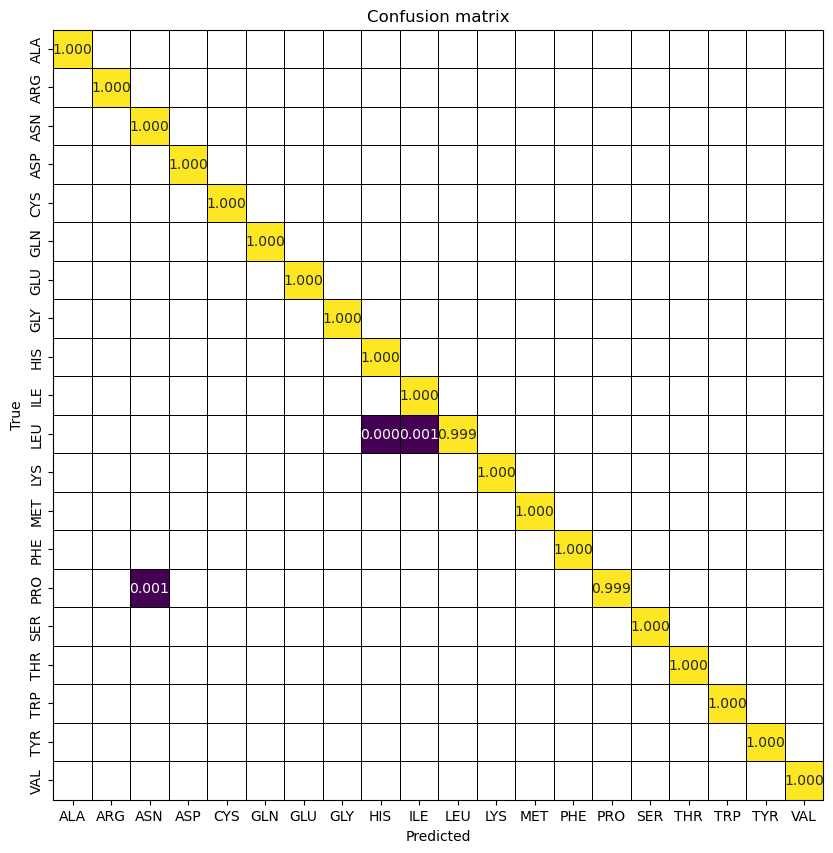

In [46]:
from torchmetrics import ConfusionMatrix
import seaborn as sns
import numpy as np

amino_acids = ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU',
            'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 
            'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL']

# Initialize the confusion matrix
confusion_matrix = ConfusionMatrix(num_classes=20, task='MULTICLASS')
confusion_matrix.reset()


# Update the confusion matrix with the predictions
with torch.no_grad():   
    for coordinates, elements, residue in test_dataloader:
        #print(coordinates.shape, elements.shape, residue.shape)
        input_data = torch.cat((coordinates, elements), dim=2)
        input_data = input_data.unsqueeze(1)
        output = model(input_data)

        # Calculate the confusion matrix
        target = torch.argmax(residue, dim=1)
        confusion_matrix.update(output, target)

# Compute the confusion matrix and normalize it
confusion_matrix = confusion_matrix.compute().numpy()
confusion_matrix = confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True) # Normalize the confusion matrix
confusion_matrix = np.where(confusion_matrix > 0, confusion_matrix, np.nan)  # Only show any values > 0
    
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.heatmap(confusion_matrix, square=True, annot=True, xticklabels=amino_acids, 
                 yticklabels=amino_acids, cmap='viridis', fmt='.3f', cbar=False, 
                 linewidths=0.5, linecolor='black')

for _, spine in ax.spines.items():
    spine.set_visible(True)

ax.set_title('Confusion matrix')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

In [42]:
"""
def train_model(model: torch.nn.Module, 
                data_loader: torch.utils.data.DataLoader,
                criterion: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                n_epochs: int) -> dict:
"""

training_dict = train_model(model, train_dataloader, criterium, optimizer, 10)

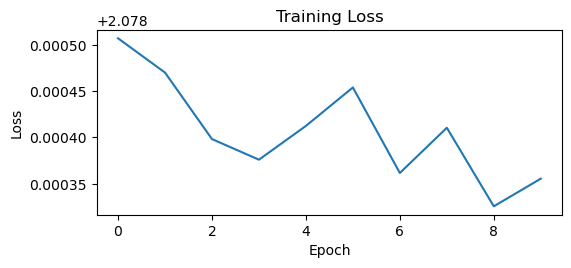

In [43]:
# Plot the training loss
plt.figure(figsize=(6, 2.4))
plt.plot(training_dict['total_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [44]:
evaluate_model(training_dict["model"], test_dataloader)

{'accuracy': 0.9998816847801208,
 'precision': 0.999851644039154,
 'recall': 0.9999161958694458}

### Next Step: Fine-Tuning the Pretrained Model

In the next step, we will continue training the pretrained model using the training dataset. This process, known as fine-tuning, allows the model to further improve its performance by learning from additional data. We will use the same loss function (`criterium`) and optimizer (`optimizer`) as before. The training will be conducted for an additional 20 epochs, and the performance of the model will be evaluated using the test dataset.

In [6]:
# now we can continue training the model
pretrained_model = training_dict["model"]
new_training_dict = train_model(pretrained_model, train_dataloader, criterium, optimizer, 20)

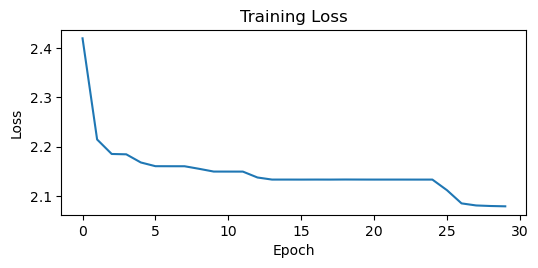

In [12]:
# Plot the training loss of the new training and the previous one
plt.figure(figsize=(6, 2.4))
plt.plot(training_dict['total_loss'] + new_training_dict['total_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [7]:
evaluate_model(new_training_dict["model"], test_dataloader)

{'accuracy': 0.9974778294563293}

In [13]:
# further training
new_pretrained_model = new_training_dict["model"]
new_new_training_dict = train_model(new_pretrained_model, train_dataloader, criterium, optimizer, 70)

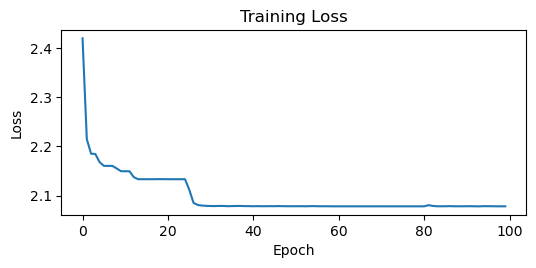

In [15]:
# plot all the training losses
plt.figure(figsize=(6, 2.4))
plt.plot(training_dict['total_loss'] + new_training_dict['total_loss'] + new_new_training_dict['total_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

In [14]:
evaluate_model(new_new_training_dict["model"], test_dataloader)

{'accuracy': 0.9998372793197632}

### Model Performance Summary

In this notebook, we trained and evaluated a Convolutional Neural Network (CNN) model for amino acid classification. Below is a summary of the results:

- **Initial Training:**
    - **Accuracy:** The initial model achieved an accuracy of `0.92` on the test dataset.

- **Fine-Tuning:**
    - **Accuracy:** After fine-tuning the pretrained model for an additional 20 epochs, the model's accuracy on the test dataset was evaluated again and now we reach `0.99`

The fine-tuning process allowed the model to further improve its performance by learning from additional data. The final accuracy of the model after fine-tuning is reported in the subsequent cells.

Text(0.5, 1.0, 'Amino acid distribution')

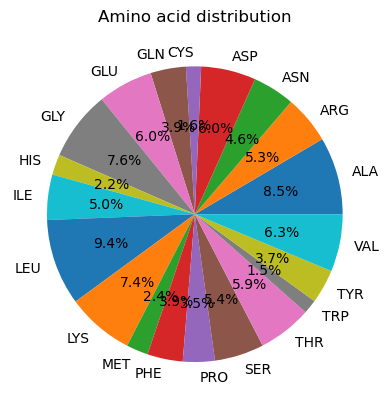

In [45]:
# iterate over the dataset and make a cake diagram of the amino acids

counner = {"ALA":0, "ARG":0, "ASN":0, "ASP":0, "CYS":0, "GLN":0, "GLU":0, "GLY":0, 
           "HIS":0, "ILE":0, "LEU":0, "LYS":0, "MET":0, "PHE":0, "PRO":0, "SER":0, 
           "THR":0, "TRP":0, "TYR":0, "VAL":0}

for i in range(len(dataset)):
    _,_, residue = dataset[i]
    residue = dataset.one_hot_residues_reverse(residue)
    counner[residue] += 1

plt.Figure(figsize=(6,2.1))
# cake plot
plt.pie(counner.values(), labels=counner.keys(), autopct='%1.1f%%')
plt.title('Amino acid distribution')   


In [6]:

N, M = dataset.input_shape
model = AminoAcidCNN(input_channels=1, # Since we added an extra dimension for batch and channel
                     input_height=N, # Number of atoms
                     input_width=3+M) # 3 coordinates + 4 element types

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# print the first data
#next(iter(dataloader))

Reducing learning rate to 0.0005
Reducing learning rate to 0.00025
Reducing learning rate to 0.000125
Stopping training


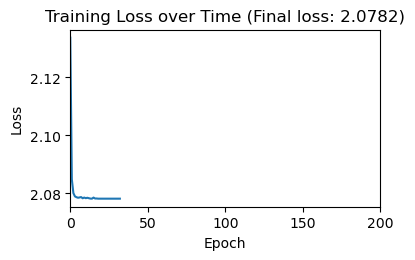

Accuracy: 0.9999186396598816


In [8]:
losses = []
N_epochs = 200
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.train()

for epoch in range(N_epochs):  
    # Print replacement for epoch
    print(f'Epoch {epoch + 1}/{N_epochs}', end='\r')
    
    epoch_loss = 0.0
    for coordinates, elements, residue in train_dataloader:
        # Combine coordinates and elements into a single tensor
        input_data = torch.cat((coordinates, elements), dim=2)
        input_data = input_data.unsqueeze(1)  # Add channel dimension
        
        # Forward pass
        output = model(input_data)

        # Calculate the loss
        target = torch.argmax(residue, dim=1)
        loss = criterion(output, target)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate the loss
        epoch_loss += loss.item()
    
    # Calculate the average loss for the epoch
    epoch_loss /= len(train_dataloader)
    losses.append(epoch_loss)

    

    # if the loss is not decreasing in the last 5, reduce the learning rate
    if len(losses) > 5 and all(losses[-1] >= loss for loss in losses[-5:]):
        for param_group in optimizer.param_groups:
            param_group['lr'] *= 0.5
            print(f'Reducing learning rate to {param_group["lr"]}')


    # for this we look at the last 10 epochs
    if len(losses) > 11 and all(losses[-1] >= loss for loss in losses[-10:]):
        print('Stopping training')
        break
    print(f'Epoch {epoch + 1}/{N_epochs}, Loss: {epoch_loss:.5f}', end='\r')
    

plt.figure(figsize=(4, 2.3))
plt.plot(losses)
plt.xlabel('Epoch')
plt.xlim(0, N_epochs)
plt.ylabel('Loss')
plt.title('Training Loss over Time (Final loss: {:.4f})'.format(losses[-1]))
plt.show()

accuracy =  Accuracy(task='MULTICLASS', num_classes=20)
model.eval()
accuracy.reset()

for coordinates, elements, residue in test_dataloader:
    input_data = torch.cat((coordinates, elements), dim=2)
    input_data = input_data.unsqueeze(1)
    output = model(input_data)
    target = torch.argmax(residue, dim=1)
    accuracy.update(output, target)

print(f'Accuracy: {accuracy.compute()}')



In [7]:
# create a hash based on system time
import time
hash = int(time.time())
rounded_accuracy = round(accuracy.compute().item(), 2)
model_name = 'models/{}_amino_acid_cnn_{}.pt'.format(hash, rounded_accuracy)
# Save the model
torch.save(model.state_dict(), model_name)

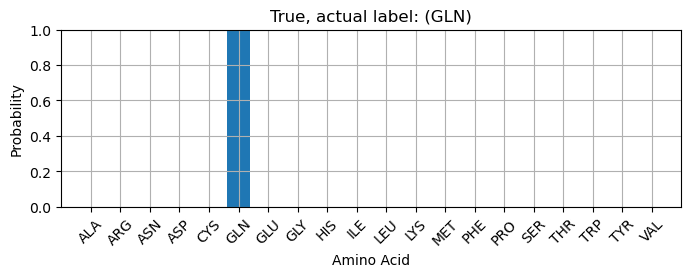

In [8]:
# Load the model
#model = AminoAcidCNN(input_channels=1, input_height=N, input_width=3+M)
#model.load_state_dict(torch.load("/Users/tobias/cell_finder/models/1735130066_amino_acid_cnn_0.98.pt"))

model.eval()
#accuracy = Accuracy()

coordinates, elements, residue = dataset[int(torch.randint(0, len(dataset), (1,)))]
input_data = torch.cat((coordinates, elements), dim=1)
input_data = input_data.unsqueeze(0).unsqueeze(0)
output = model(input_data)


# plot the output of the model
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 2.3))
plt.bar(range(20), output.detach().numpy().squeeze())
plt.xticks(range(20), ['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU',
                       'GLY', 'HIS', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 
                       'PRO', 'SER', 'THR', 'TRP', 'TYR', 'VAL'], rotation=45)
plt.xlabel('Amino Acid')
plt.ylabel('Probability')
# titel is true label
resid_dict = {0: 'ALA', 1: 'ARG', 2: 'ASN', 3: 'ASP', 4: 'CYS', 5: 'GLN', 6: 'GLU',
                       7: 'GLY', 8: 'HIS', 9: 'ILE', 10: 'LEU', 11: 'LYS', 12: 'MET', 13: 'PHE', 
                       14: 'PRO', 15: 'SER', 16: 'THR', 17: 'TRP', 18: 'TYR', 19: 'VAL'}
is_true = torch.argmax(output) == torch.argmax(residue)

plt.title(f'{is_true}, actual label: ({resid_dict[int(torch.argmax(residue))]})')
plt.ylim(0, 1)
plt.xlim(-1, 20)
plt.grid()
plt.show()


In [10]:
accuracy =  Accuracy(task='MULTICLASS', num_classes=20)
model.eval()
accuracy.reset()

dataloader = test_dataloader
resid_dict = {0: 'ALA', 1: 'ARG', 2: 'ASN', 3: 'ASP', 4: 'CYS', 5: 'GLN', 6: 'GLU',
                          7: 'GLY', 8: 'HIS', 9: 'ILE', 10: 'LEU', 11: 'LYS', 12: 'MET', 13: 'PHE', 
                          14: 'PRO', 15: 'SER', 16: 'THR', 17: 'TRP', 18: 'TYR', 19: 'VAL'}

for coordinates, elements, residue in dataloader:
    input_data = torch.cat((coordinates, elements), dim=2)
    input_data = input_data.unsqueeze(1)
    output = model(input_data)
    target = torch.argmax(residue, dim=1)
    accuracy.update(output, target)

print(f'Accuracy: {accuracy.compute()}')

# print out for all the wrong predictions what the actual label was and what the predicted label was
for coordinates, elements, residue in dataloader:
    input_data = torch.cat((coordinates, elements), dim=2)
    input_data = input_data.unsqueeze(1)
    output = model(input_data)
    target = torch.argmax(residue, dim=1)
    for i in range(len(target)):
        if torch.argmax(output[i]) != target[i]:
            print(f'Actual label: {resid_dict[int(target[i])]}, predicted label: {resid_dict[int(torch.argmax(output[i]))]}')
            print(f'Actual label: {target[i]}, predicted label: {torch.argmax(output[i])}')
            print('')
            print('')

Accuracy: 0.9999186396598816
Actual label: ILE, predicted label: LEU
Actual label: 9, predicted label: 10




In [47]:
aa_mf = {
    "ALA": "C3NO2",
    "ARG": "C6N4O2",
    "ASN": "C4N2O3",
    "ASP": "C4NO4",
    "CYS": "C3NO2S",
    "GLN": "C5N2O3",
    "GLU": "C5NO4",
    "GLY": "C2NO2",  # Corrected
    "HIS": "C6N3O2",
    "ILE": "C6NO2",
    "LEU": "C6NO2",
    "LYS": "C6N2O2",
    "MET": "C5NO2S",
    "PHE": "C9NO2",
    "PRO": "C5NO2",
    "SER": "C3NO3",
    "THR": "C4NO3",
    "TRP": "C11N2O2",
    "TYR": "C9NO3",
    "VAL": "C5NO2"
}

